In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Пример с использованием OpenCV

In [2]:
def stitch_images(images):
    """Производит операцию по склеиванию изображений."""
    # Создается объект класса Stitcher
    stitcher = cv2.Stitcher_create()

    # Операция склеивания выполняется методом stitch
    _ , result = stitcher.stitch(images)

    return result

In [4]:
# Шаг 1: Загрузка изображений
img1 = cv2.imread("street_1.jpeg")
img2 = cv2.imread("street_2.jpeg")

if img1 is None or img2 is None:
    raise FileNotFoundError("Одно из изображений не найдено.")

# Шаг 2: Преобразование в градации серого
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

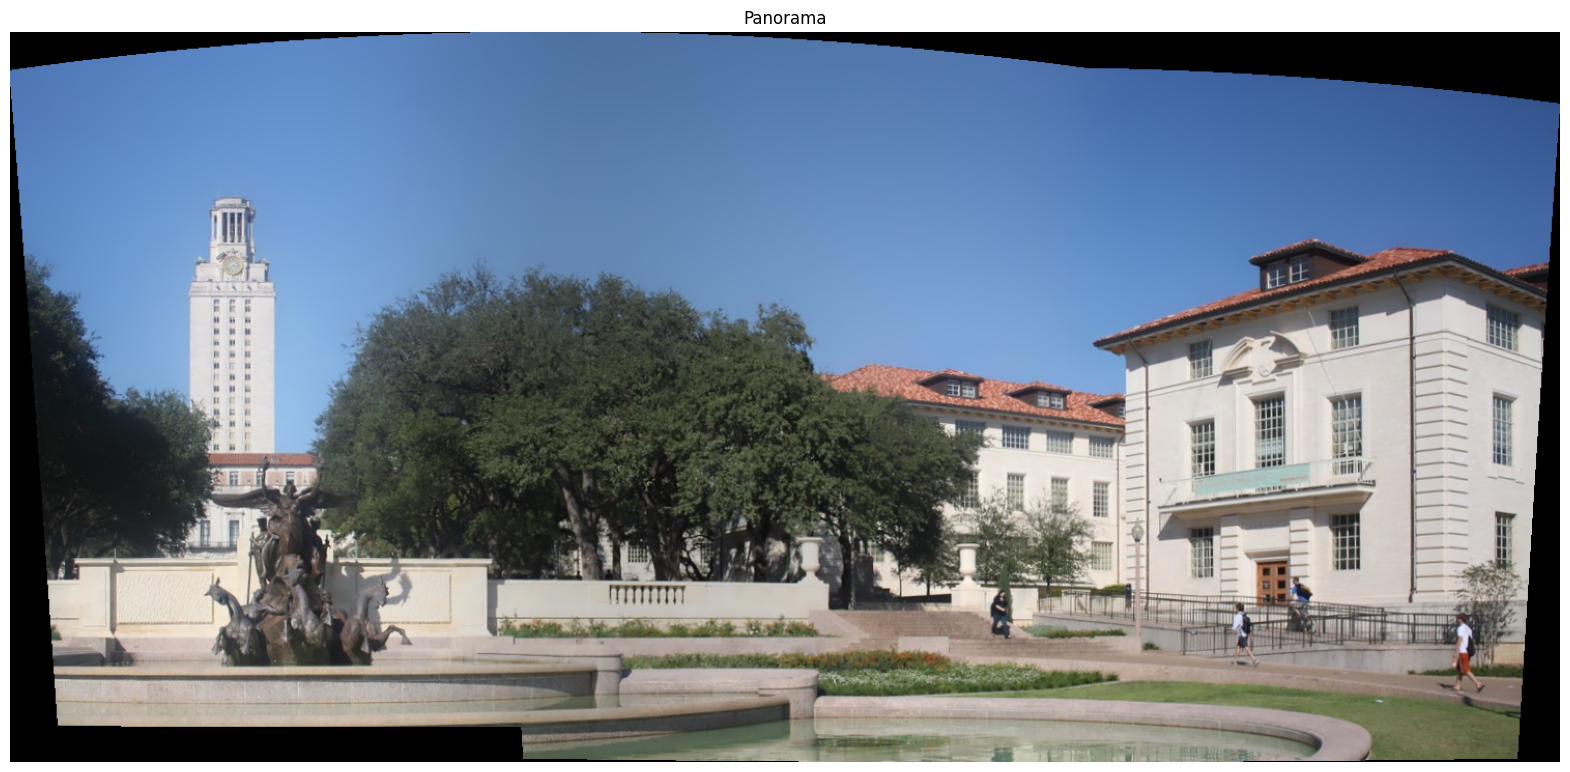

In [5]:
result = stitch_images([img1, img2])

# Отображение результата
plt.figure(figsize=(20, 10))
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Panorama")
plt.show()

# Пример с использованием SIFT метода для отбора ключевых точек

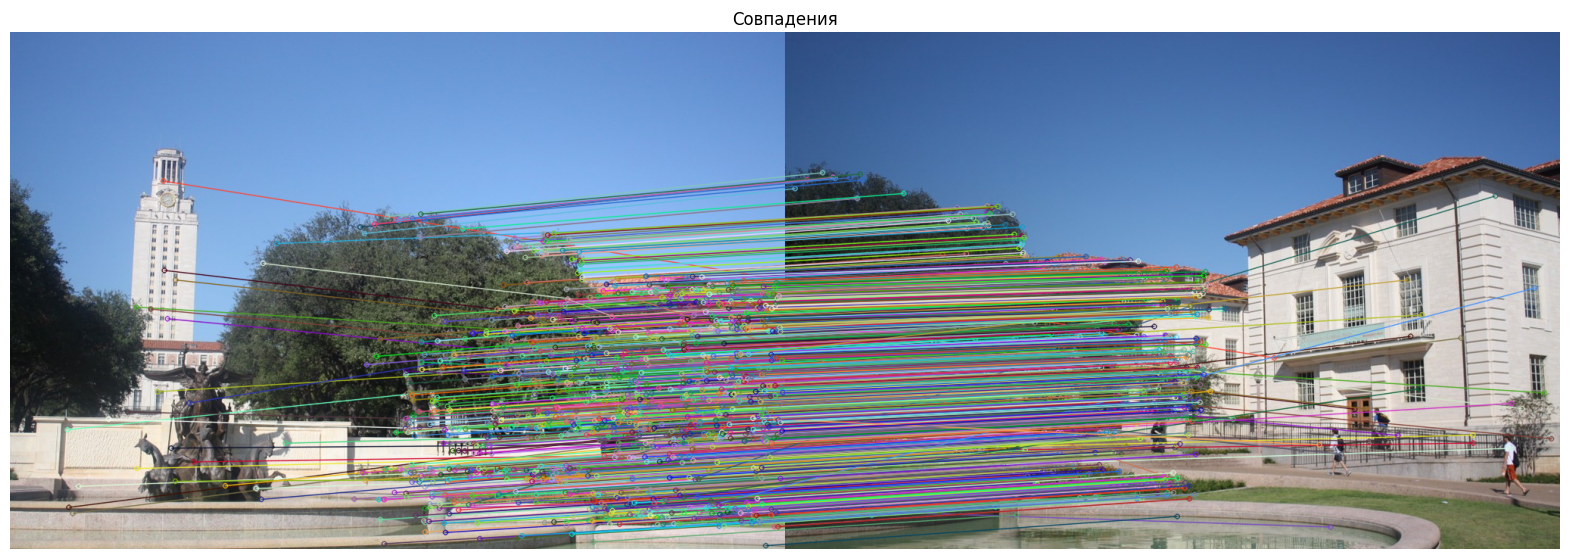

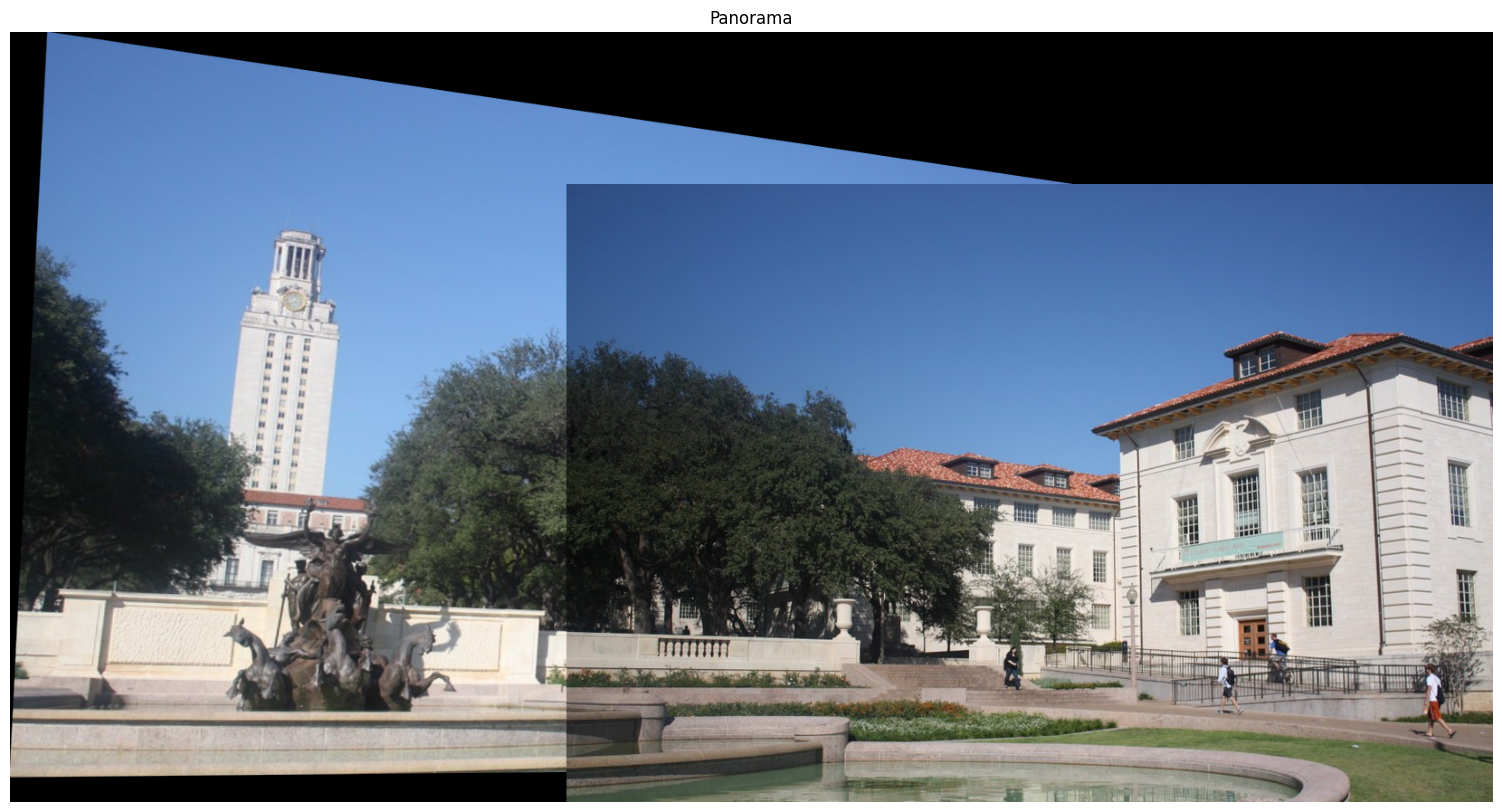

In [6]:
# Загрузка изображений и создание панорамы
# подумать о том, важен ли порядок - первое изображение то, что слева или наоборот?
image1_path = "street_1.jpeg"  # Путь к первому изображению
image2_path = "street_2.jpeg"  # Путь ко второму изображению

img1 = cv2.imread(image1_path)
img2 = cv2.imread(image2_path)

if img1 is None or img2 is None:
    raise FileNotFoundError("Одно из изображений не найдено.")

# Шаг 1: Преобразование в градации серого
# (Для упрощения обработки изображений и поиска ключевых точек преобразуем изображения в оттенки серого с помощью)
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# Шаг 2: Инициализация SIFT и обнаружение ключевых точек
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(gray1, None)
kp2, des2 = sift.detectAndCompute(gray2, None)

# Шаг 3: Использование FLANN для быстрого сопоставления дескрипторов между ключевыми точками
index_params = dict(algorithm=1, trees=5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)

# Шаг 4: Фильтрация совпадений с использованием правила "доброго соседа"
# Проверяется как расстояние "похожести" между ключевыми точками,
# так и их количество
good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:  # Порог фильтрации
        good_matches.append(m)

# Проверка достаточного количества совпадений
if len(good_matches) < 10:
    raise ValueError("Недостаточно совпадений для построения панорамы.")

# Визуализация совпадений (опционально) через matplotlib
img_matches = cv2.drawMatches(
    img1, kp1, img2, kp2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)
plt.figure(figsize=(20, 10))
plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Совпадения")
plt.show()

# Шаг 5: Получение координат точек (из совпавших дескрипторов извлекаем координаты ключевых точек)
src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

# Шаг 6: Построение матрицы гомографии (Гомография описывает, как одно изображение трансформируется, чтобы соответствовать другому)
H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

# Шаг 7: Вычисление размеров результирующего изображения
height1, width1 = img1.shape[:2]
height2, width2 = img2.shape[:2]

points_img2 = np.float32([[0, 0], [0, height2], [width2, height2], [width2, 0]]).reshape(-1, 1, 2)
points_img1 = np.float32([[0, 0], [0, height1], [width1, height1], [width1, 0]]).reshape(-1, 1, 2)

# С помощью гомографии трансформируем углы второго изображения
transformed_points = cv2.perspectiveTransform(points_img2, H)
all_points = np.concatenate((points_img1, transformed_points), axis=0)

# Объединяем углы первого и второго изображений, чтобы определить размеры результирующего изображения
[x_min, y_min] = np.int32(all_points.min(axis=0).flatten())
[x_max, y_max] = np.int32(all_points.max(axis=0).flatten())

translation_dist = [-x_min, -y_min]
result_width = x_max - x_min
result_height = y_max - y_min

# Шаг 8: Создаём трансляционную матрицу и корректируем матрицу гомографии
# Добавляем смещение, чтобы избежать отрицательных координат при трансформации
translation_matrix = np.array([[1, 0, translation_dist[0]], [0, 1, translation_dist[1]], [0, 0, 1]])
H = translation_matrix @ H

# Шаг 9: Преобразуем первое изображение с помощью cv2.warpPerspective, используя матрицу гомографии
# В результирующее изображение добавляем второе изображение без изменений
# Накладываем второе изображение в заданные границы
panorama = cv2.warpPerspective(img1, H, (result_width, result_height))
panorama[translation_dist[1]:translation_dist[1] + height2, translation_dist[0]:translation_dist[0] + width2] = img2

# Отображение результата
plt.figure(figsize=(20, 10))
plt.imshow(cv2.cvtColor(panorama, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Panorama")
plt.show()

# ДЗ: Напишите функцию или класс для реализации метода создания панорамы по двум изображениям. Функция должна принимать на вход путь к изображениям и выдавать результат панорамы, который затем можно использовать (не только вывести на экран но и реализовать возврат для передачи панорамы в другие переменные для работы). Приведите примеры по паре изображений выше а также по паре изображений mountain_*.jpg.

In [107]:
def stitch_images(images):
    """Производит операцию по склеиванию изображений."""
    # Создается объект класса Stitcher
    stitcher = cv2.Stitcher_create()

    # Операция склеивания выполняется методом stitch
    _ , result = stitcher.stitch(images)

    return result

def make_panorama(img1, img2, res):
    if img1 is None or img2 is None:
        raise FileNotFoundError("Одно из изображений не найдено.")

    result = stitch_images([img1, img2])
    cv2.imwrite(f'{res}.jpg', result)

    # Отображение результата
    plt.figure(figsize=(20, 10))
    plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title("Panorama")
    plt.show()

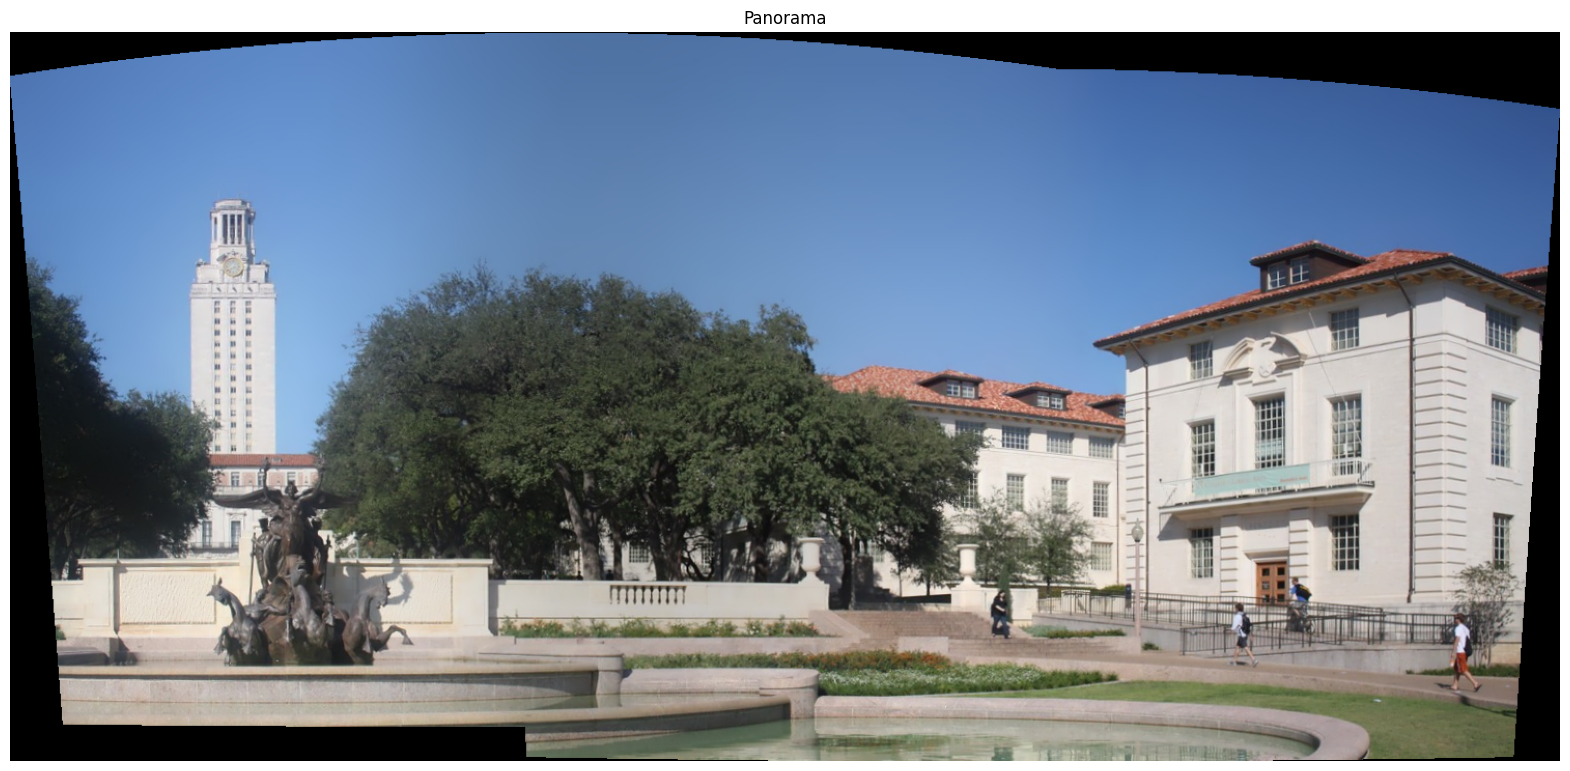

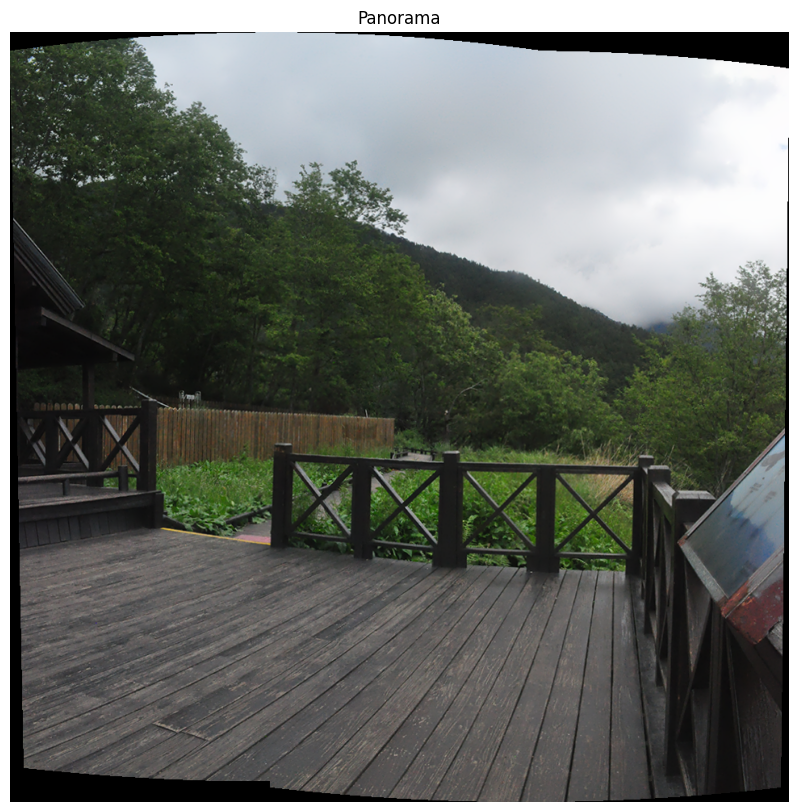

In [108]:
street1 = cv2.imread("street_1.jpeg")
street2 = cv2.imread("street_2.jpeg")

mountain_1 = cv2.imread("mountain_1.jpg")
mountain_2 = cv2.imread("mountain_2.jpg")

make_panorama(img1=street1, img2=street2, res='res_street')
make_panorama(img1=mountain_1, img2=mountain_2, res='res_mountain')

# Сравните результаты выполнения операций между классом Stitcher_create из OpenCV и кастомным методом через алгоритм SIFT. Что можно улучшить в выходном результате?

# Доп задание*, которое также будем проходить на практике: Как нужно обновить написанный выше код, чтобы можно было подавать на вход более 2-ух изображения для создания панорамы?

In [113]:
def make_panorama(image_paths):
    if len(image_paths) < 2:
        raise ValueError("Необходимо минимум два изображения для создания панорамы.")
    
    # Загрузка первого изображения
    base_img = cv2.imread(image_paths[0])
    if base_img is None:
        raise FileNotFoundError(f"Изображение {image_paths[0]} не найдено.")
    
    for i in range(1, len(image_paths)):
        next_img = cv2.imread(image_paths[i])
        if next_img is None:
            raise FileNotFoundError(f"Изображение {image_paths[i]} не найдено.")
        
        # Преобразование в градации серого
        gray1 = cv2.cvtColor(base_img, cv2.COLOR_BGR2GRAY)
        gray2 = cv2.cvtColor(next_img, cv2.COLOR_BGR2GRAY)
        
        # Инициализация SIFT и обнаружение ключевых точек
        sift = cv2.SIFT_create()
        kp1, des1 = sift.detectAndCompute(gray1, None)
        kp2, des2 = sift.detectAndCompute(gray2, None)
        
        # Сопоставление ключевых точек с использованием FLANN
        index_params = dict(algorithm=1, trees=5)
        search_params = dict(checks=50)
        flann = cv2.FlannBasedMatcher(index_params, search_params)
        matches = flann.knnMatch(des1, des2, k=2)
        
        # Фильтрация совпадений
        good_matches = [m for m, n in matches if m.distance < 0.75 * n.distance]
        if len(good_matches) < 10:
            raise ValueError("Недостаточно совпадений для построения панорамы.")
        
        # Получение координат точек
        src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        
        # Построение матрицы гомографии
        H, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        
        # Вычисление размеров результирующего изображения
        height, width = next_img.shape[:2]
        points_img2 = np.float32([[0, 0], [0, height], [width, height], [width, 0]]).reshape(-1, 1, 2)
        transformed_points = cv2.perspectiveTransform(points_img2, H)
        all_points = np.concatenate((np.float32([[0, 0], [0, base_img.shape[0]], 
                                                  [base_img.shape[1], base_img.shape[0]], [base_img.shape[1], 0]]).reshape(-1, 1, 2),
                                        transformed_points), axis=0)
        
        [x_min, y_min] = np.int32(all_points.min(axis=0).flatten())
        [x_max, y_max] = np.int32(all_points.max(axis=0).flatten())
        translation_dist = [-x_min, -y_min]
        result_width = x_max - x_min
        result_height = y_max - y_min
        
        # Коррекция матрицы гомографии
        translation_matrix = np.array([[1, 0, translation_dist[0]], [0, 1, translation_dist[1]], [0, 0, 1]])
        H = translation_matrix @ H
        
        # Преобразование базового изображения
        panorama = cv2.warpPerspective(base_img, H, (result_width, result_height))
        panorama[translation_dist[1]:translation_dist[1] + height, translation_dist[0]:translation_dist[0] + width] = next_img
        
        # Установка текущего панорамного изображения как базового для следующего шага
        base_img = panorama
        
    cv2.imwrite('res.jpg', base_img)
    
    # Отображение результата
    plt.figure(figsize=(20, 10))
    plt.imshow(cv2.cvtColor(base_img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title("Panorama")
    plt.show()
    
    return base_img

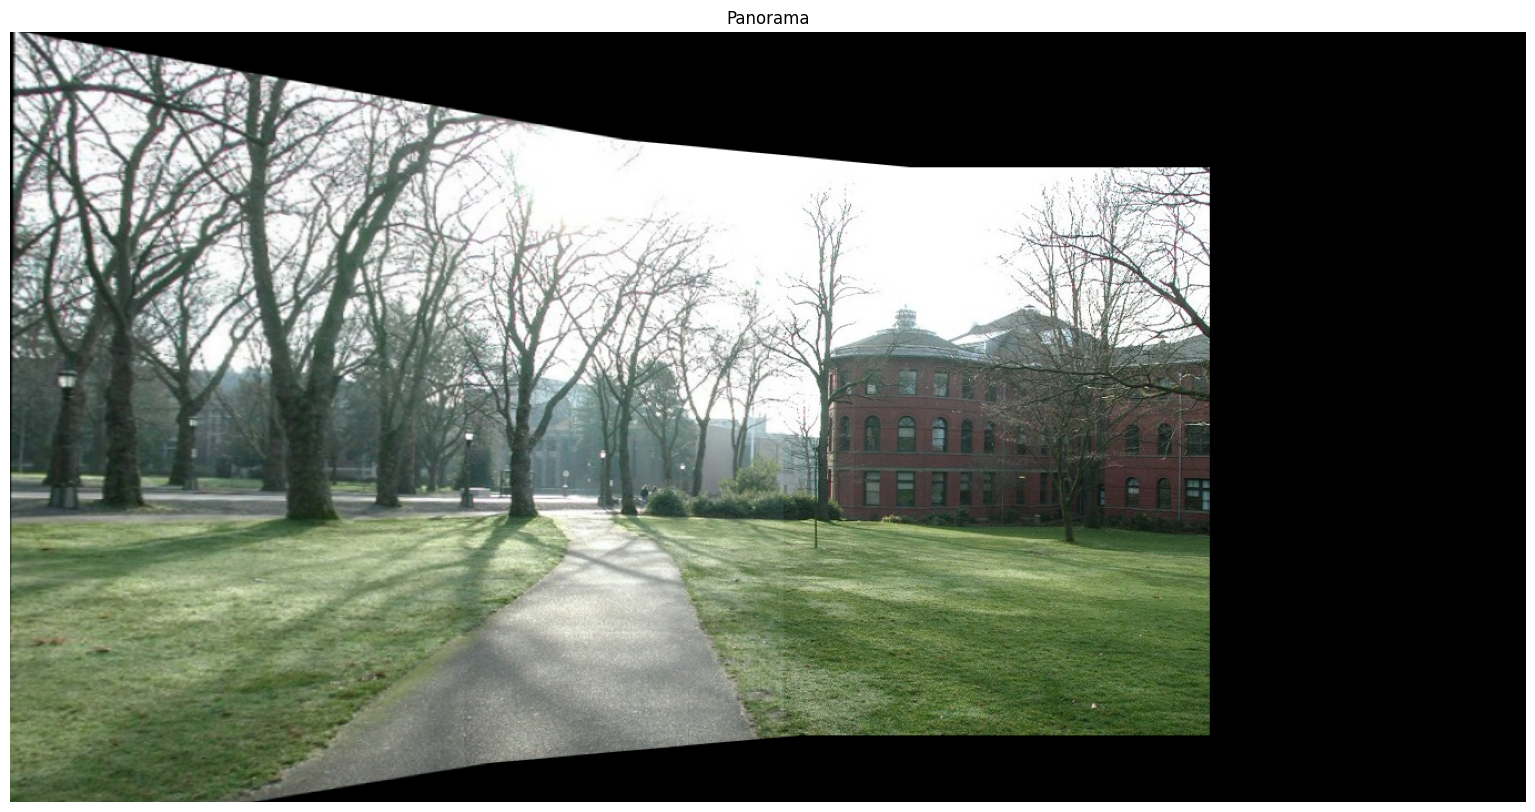

array([[[ 0,  0,  0],
        [ 0,  0,  0],
        [18, 18, 18],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [18, 18, 18],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [18, 18, 17],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       ...,

       [[40, 79, 57],
        [35, 73, 51],
        [31, 70, 46],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[35, 72, 50],
        [30, 67, 45],
        [28, 65, 42],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[42, 78, 56],
        [42, 78, 56],
        [43, 79, 57],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]]], dtype=uint8)

In [114]:
images = [
'parrington_1.jpg',
'parrington_2.jpg',
'parrington_3.jpg',]
make_panorama(images)